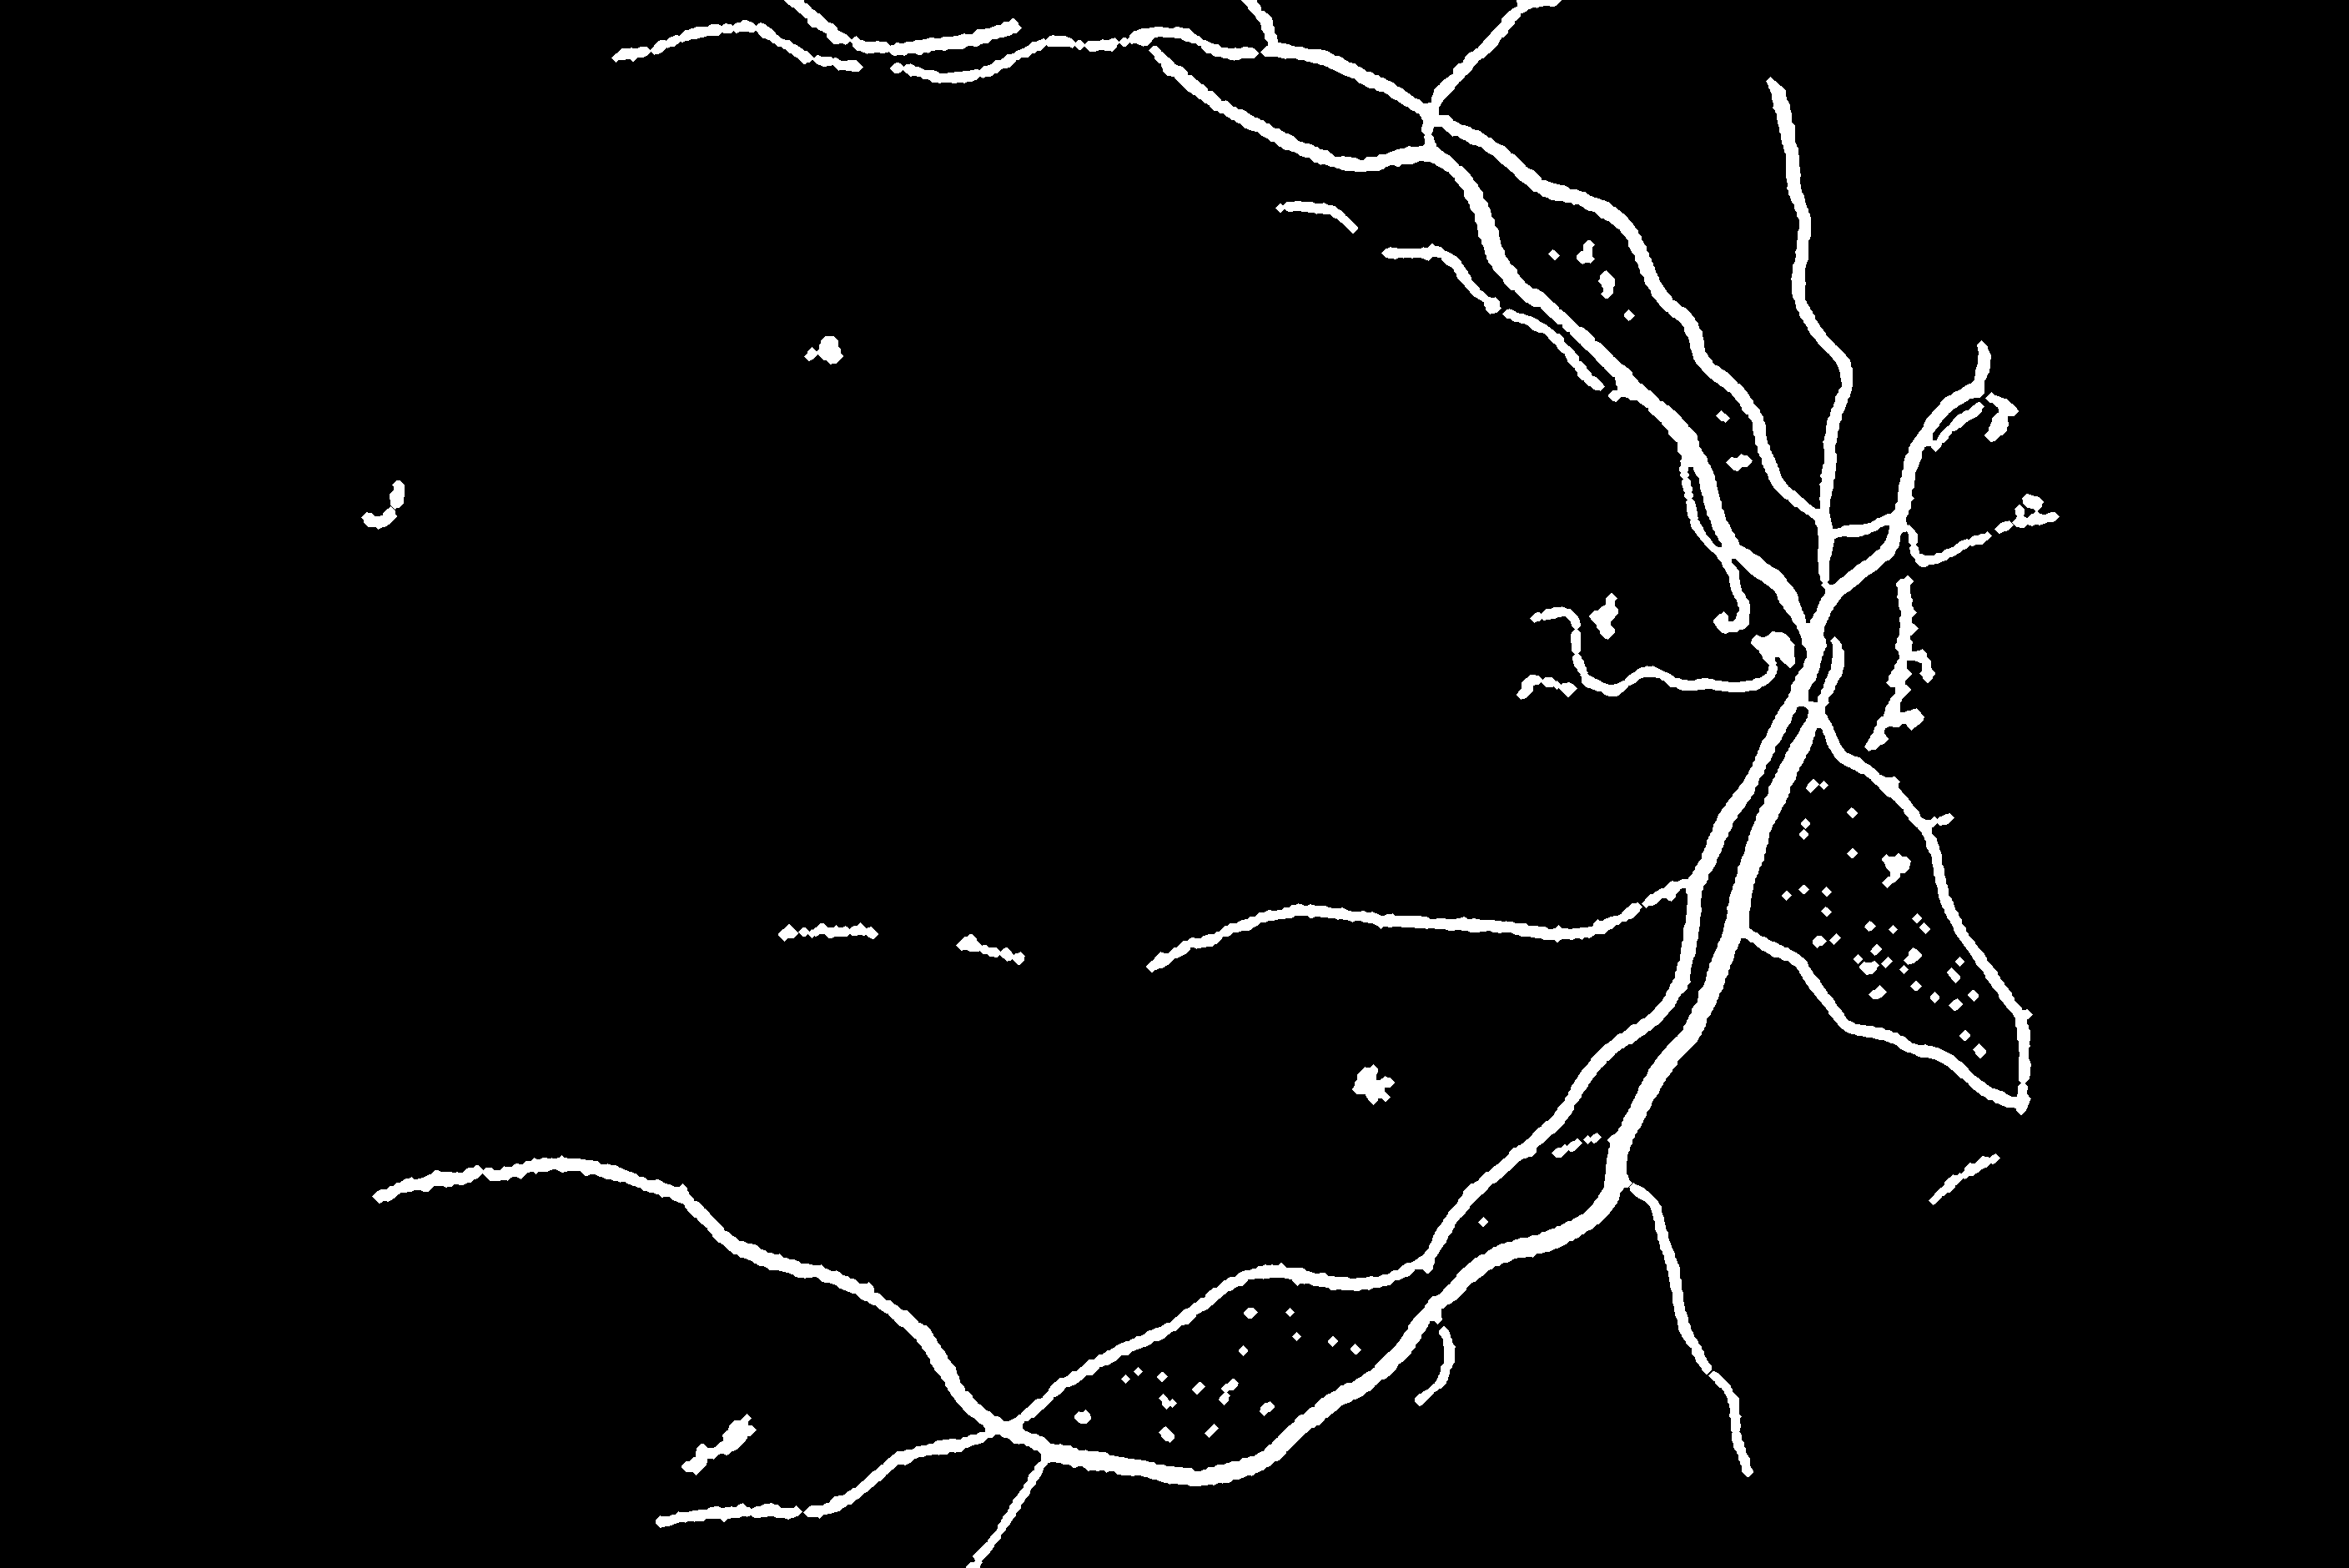

True

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def delete_small_components(image, size):
    _, blackAndWhite = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(blackAndWhite, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1]   
    image = np.zeros(labels.shape, np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= size and np.mean(image[labels == i + 1]) < 50:  
            image[labels == i + 1] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image
 
def kernel(num1, num2):
    return np.ones((num1, num2), np.uint8)

def get_large_vessels(image):
    struct_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, struct_kernel, iterations=5)

    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 800:
            cv2.drawContours(opening, [c], -1, (0, 0, 0), -1)
    return opening


def remove_background(image, mask):
    image = cv2.bitwise_and(cv2.bitwise_not(image), cv2.bitwise_not(image), mask=mask)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel(5, 5))
    return image


img = cv2.imread('fundus.jpeg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

l_b = np.array([0, 0, 30])
u_b = np.array([255, 255, 255])

mask = cv2.inRange(hsv, l_b, u_b)
mask = cv2.erode(mask, kernel(5, 5), iterations=30)

grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
image = cv2.adaptiveThreshold(grayscale, 250, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 55, 1)
 
threshold = cv2.fastNlMeansDenoising(image, 1.5, 5, 5)
 
remove_small6 = delete_small_components(threshold, 150)
 
large_vessels = get_large_vessels(remove_background(remove_small6, mask))
cv2_imshow(large_vessels)
cv2.imwrite('Large blood vessles.jpg', large_vessels)